# Исследование тарифных планов оператора сотовой связи «Мегалайн»

Заказчик – компания «Мегалайн», федеральный оператор сотовой связи. 
Клиентам компании предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. 
Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше (приносит большую прибыль).

## Общая информация

In [35]:
# подключение рабочих библиотек и настроек

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st


sns.set_palette(palette='Set1')
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None  # default='warn'

In [36]:
# чтение файлов и сохранение датафреймов 

users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')

In [37]:
# просмотр информации о датафреймах

for data in [calls, internet, messages, users, tariffs]:
    data.info()
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 

### Вывод

Мы загрузили и рассмотрели полученные от заказчика датасеты. В таблицах содержатся записи по 500 клиентам.

Обнаружены пропущенные значения в столбце `churn_date`. Согласно документации, в этот столбец записываются данные о дате прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Очевидно, что отсутствие данных здесь – не ошибка, поэтому заполнять или заменять пропуски не требуется.


Подготовим данные к анализу: поменяем тип данных в столбцах с датами, переименуем столбцы с названиями тарифов, создадим новые столбцы с рассчитанными значениями.

## Предобработка данных

### Приведем данные к корректным типам

In [38]:
users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d')
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m-%d')
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m-%d')
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d')

### Заменим название столбца

Поменяем `tariff_name` на `tariff` в датафрейме `tariffs`. Это позволит объединить два датафрейма по полю с одинаковым названием.

In [39]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

### Рассчитаем и добавим в таблицы недостающие значения, необходимые для анализа

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

Округлим значения длительности для каждого звонка отдельно. Переведем минуты в секунды и округлим в большую сторону.
Звонки длительностью 0 **не заменяем** – это пропущенные звонки по условию задачи, они не оплачиваются, а значит – не округляются.

In [40]:
# округление и смена типа на целочисленный в новом столбце

calls['duration_rounded'] = np.ceil(calls['duration']).astype('int')

### Создадим сводные таблицы по месяцам для каждого типа связи. А затем соберем общий датафрейм со всеми данными:

In [41]:
# создание нового столбца month и сводной таблицы для calls

calls['month'] = calls['call_date'].dt.month
calls_pivot = calls \
    .groupby(['user_id', 'month'], as_index=False) \
    .agg({'duration_rounded' : 'sum', 'call_date' : 'count'}) \
    .rename(columns=({'duration_rounded' : 'minutes_total', 'call_date' : 'calls_total'})) \
    .fillna(0)

calls_pivot.head(10)

,user_id,month,minutes_total,calls_total
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
5,1000,10,350,57
6,1000,11,338,43
7,1000,12,333,46
8,1001,11,430,59
9,1001,12,414,63


In [42]:
# создание сводной таблицы для messages и нового столбца month

messages['month'] = messages['message_date'].dt.month
messages_pivot = messages \
    .groupby(['user_id', 'month'], as_index=False) \
    .agg({'message_date' : 'count'}) \
    .rename(columns=({'message_date' : 'messages_total'})) \
    .fillna(0)

messages_pivot.head(10)

,user_id,month,messages_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [43]:
# создание сводной таблицы для messages и нового столбца month

internet['month'] = internet['session_date'].dt.month
internet_pivot = internet \
    .groupby(['user_id', 'month'], as_index=False) \
    .agg({'mb_used' : 'sum'}) \
    .rename(columns=({'mb_used' : 'mb_used_total'}))

# функция для округления мегабайт в гигабайты
def roundup(x):
    return int(np.ceil(x / 1024.0) * 1024)

# добавление столбца с округленными значениями
internet_pivot['mb_used_total'] = internet_pivot['mb_used_total'].apply(roundup) \
    .fillna(0)

internet_pivot.head(10)

,user_id,month,mb_used_total
0,1000,5,3072
1,1000,6,23552
2,1000,7,14336
3,1000,8,14336
4,1000,9,15360
5,1000,10,15360
6,1000,11,15360
7,1000,12,10240
8,1001,11,18432
9,1001,12,14336


In [44]:
# сборка таблиц активностей в один датафрейм 

activities = calls_pivot.merge(messages_pivot, how='outer') \
    .merge(internet_pivot, how='outer')

In [45]:
# сборка финального датафрейма пользователей, активностей и тарифов

df = users.merge(activities, how='left') \
    .merge(tariffs)

### Рассчитаем помесячную выручку с каждого пользователя за вычетом бесплатного лимита из суммарного количества звонков, сообщений и интернет-трафика.

In [46]:
# добавление новых столбцов за вычетом тарифного лимита

df['paid_minutes'] = df['minutes_total'] - df['minutes_included']
df['paid_messages'] = df['messages_total'] - df['messages_included']
df['paid_mb'] = df['mb_used_total'] - df['mb_per_month_included']

В тех случаях, где клиентом было израсходовано меньше, чем предлагается тарифом получились отрицательные значения. Избавимся от них, заменив на 0:

In [47]:
# отрицательные значения меняем на 0

df.loc[df['paid_minutes'] < 0, 'paid_minutes'] = 0
df.loc[df['paid_messages'] < 0, 'paid_messages'] = 0
df.loc[df['paid_mb'] < 0, 'paid_mb'] = 0

# заменяем пропуски нулями

df['paid_minutes'] = df['paid_minutes'].fillna(0)
df['paid_messages'] = df['paid_messages'].fillna(0)
df['paid_mb'] = df['paid_mb'].fillna(0)

Добавим новый столбец для абонентской платы сверх тарифа. Сложив суммы в столбцах абонентской платы и тарифного плана, получим сумму месячной выручки для каждой записи.

In [48]:
# добавление нового столбца с расчетом суммы перерасхода

df['additional_payment'] \
    = (df.paid_minutes * df.rub_per_minute) \
    + (df.paid_messages * df.rub_per_message) \
    + ((df.paid_mb / 1024) * df.rub_per_gb)


# добавление нового столбца с финальной суммой

df['total_payment'] = df.additional_payment + df.rub_monthly_fee

In [49]:
# очистим датафрейм от лишних столбцов

df = df[['user_id', 'city', 'tariff', 'month', 'minutes_total', 'calls_total',
       'messages_total', 'mb_used_total', 'rub_monthly_fee', 'additional_payment', 'total_payment']]

# замена типов данных в столбцах и заполнение пропусков
to_int_list = ['month', 'messages_total', 'mb_used_total',
       'minutes_total', 'calls_total', 'additional_payment', 'total_payment']

df[to_int_list] = df[to_int_list].fillna(0).astype(int)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             3216 non-null   int64 
 1   city                3216 non-null   object
 2   tariff              3216 non-null   object
 3   month               3216 non-null   int64 
 4   minutes_total       3216 non-null   int64 
 5   calls_total         3216 non-null   int64 
 6   messages_total      3216 non-null   int64 
 7   mb_used_total       3216 non-null   int64 
 8   rub_monthly_fee     3216 non-null   int64 
 9   additional_payment  3216 non-null   int64 
 10  total_payment       3216 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 301.5+ KB


### Вывод

Мы обработали недочеты в данных – поменяли типы данных, переименовали столбцы для удобства дальнейшей работы.

Также мы создали сборный датафрейм, в котором  вновых столбцах посчитали для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Для удобства работы мы оставили только те столбцы, которые будут участвовать в расчетах. Получилось `3216` строк со сводными данными, которые предстоит проанализировать.

## Анализ данных


Опишем поведение клиентов оператора, исходя из выборки.

### Расчет среднего количества, дисперсии и стандартного отклонения.

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [51]:
# группировка по тарифам и медианные значения

tariffs_medians = df \
    .groupby(['tariff']) \
    .agg({'minutes_total' : 'median', 'messages_total' : 'median', 'mb_used_total' : 'median'}) \
    .rename(columns=({'minutes_total' : 'minutes_median', 'messages_total' : 'messages_median', \
                      'mb_used_total' : 'mb_used_median'})) \
    .astype(int)

tariffs_medians

,minutes_median,messages_median,mb_used_median
tariff,,,
smart,421,28,17408
ultra,518,38,19456


- Пользователям тарифа **smart** требуется около 421 минуты звонков, 28 сообщений и 17 Гб интернет-трафика в месяц. Медианный платеж по тарифу – 1065 рублей. 


- Пользователям тарифа **ultra** требуется около 518 минут звонков, 38 сообщений и 20 Гб интернет-трафика в месяц. Медианный платеж по тарифу – 1950 рублей.

In [52]:
print('Количество пользователей тарифа ultra:', df.query('tariff == "ultra"').user_id.value_counts().count())


Количество пользователей тарифа ultra: 149


In [53]:
print('Количество пользователей тарифа smart:', df.query('tariff == "smart"').user_id.value_counts().count())

Количество пользователей тарифа smart: 351


Сводная таблица по тарифам с расчетами стандартного отклонения и дисперсии:

In [54]:
tariffs_stats = df \
    .groupby(['tariff']) \
    .agg({'minutes_total' : [np.median, np.var, np.std], \
          'messages_total' : [np.median, np.var, np.std], \
          'mb_used_total' : [np.median, np.var, np.std]}) \
    .rename(columns=({'minutes_total' : 'minutes', \
                      'messages_total' : 'messages', \
                      'mb_used_total' : 'mb_used'})) \
    .astype(int)

tariffs_stats

minutes              messages           mb_used                  
        median     var  std   median   var std  median        var    std
tariff                                                                  
smart      421   36281  190       28   796  28   17408   34742943   5894
ultra      518  101052  317       38  2285  47   19456  102108804  10104

In [55]:
df.query('tariff == "smart"').describe().round()

,user_id,month,minutes_total,calls_total,messages_total,mb_used_total,rub_monthly_fee,additional_payment,total_payment
count,2230.0,2230.0,2230.0,2230.0,2230.0,2230.0,2230.0,2230.0,2230.0
mean,1247.0,8.0,418.0,58.0,33.0,16713.0,550.0,740.0,1290.0
std,146.0,3.0,190.0,26.0,28.0,5894.0,0.0,818.0,818.0
min,1001.0,0.0,0.0,0.0,0.0,0.0,550.0,0.0,550.0
25%,1121.0,6.0,282.0,40.0,10.0,13312.0,550.0,0.0,550.0
50%,1240.0,9.0,422.0,60.0,28.0,17408.0,550.0,471.0,1021.0
75%,1376.0,11.0,545.0,76.0,51.0,20480.0,550.0,1200.0,1750.0
max,1499.0,12.0,1435.0,198.0,143.0,38912.0,550.0,6220.0,6770.0


In [56]:
df.query('tariff == "ultra"').describe().round()

,user_id,month,minutes_total,calls_total,messages_total,mb_used_total,rub_monthly_fee,additional_payment,total_payment
count,986.0,986.0,986.0,986.0,986.0,986.0,986.0,986.0,986.0
mean,1263.0,8.0,526.0,73.0,49.0,19942.0,1950.0,120.0,2070.0
std,141.0,3.0,318.0,44.0,48.0,10105.0,0.0,376.0,376.0
min,1000.0,0.0,0.0,0.0,0.0,0.0,1950.0,0.0,1950.0
25%,1143.0,6.0,282.0,41.0,6.0,12288.0,1950.0,0.0,1950.0
50%,1277.0,9.0,518.0,74.0,38.0,19456.0,1950.0,0.0,1950.0
75%,1381.0,11.0,752.0,104.0,79.0,27648.0,1950.0,0.0,1950.0
max,1495.0,12.0,1673.0,244.0,224.0,50176.0,1950.0,2850.0,4800.0


### Построение гистограмм.

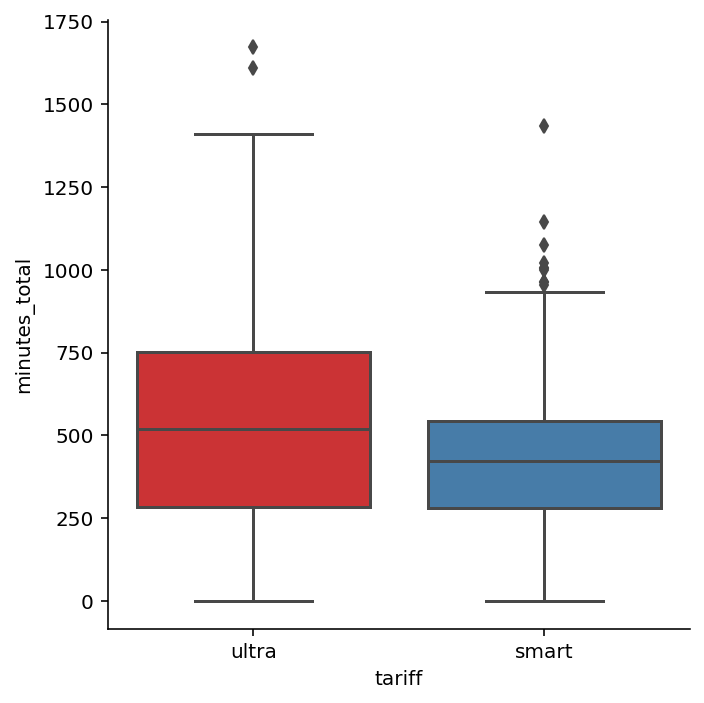

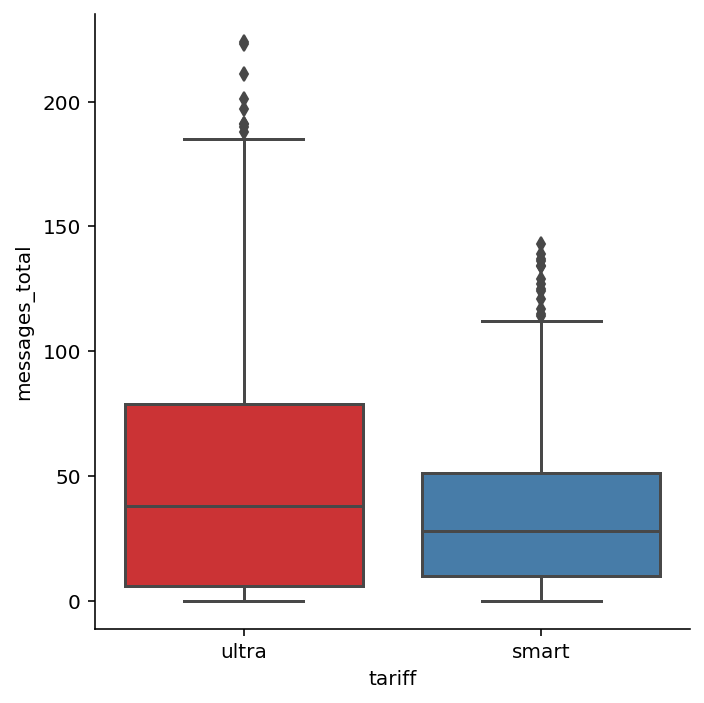

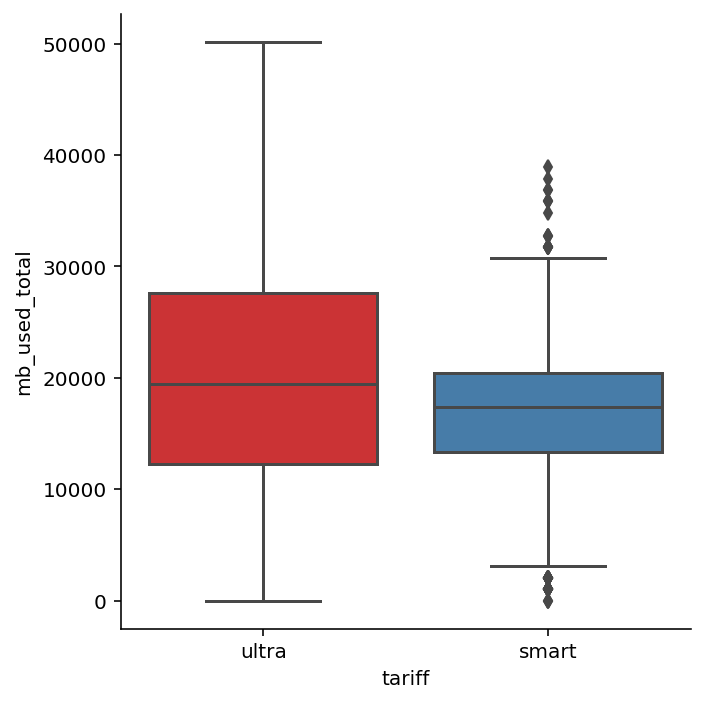

In [57]:
# боксплоты сравнения тарифов по типам связи

for col in ['minutes_total', 'messages_total', 'mb_used_total']:    
    sns.catplot(x="tariff", y=col, kind='box', data=df, orient='v')

На боксплотах видно, что показатели дорогого тарифа `ultra` имеют большую дисперсию по потраченным минутам голосовой связи, сообщениям и интернет-трафику. Медианы смещены в большую сторону. 

На более дешевом тарифе `smart` обнаружено большое количество выбросов.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


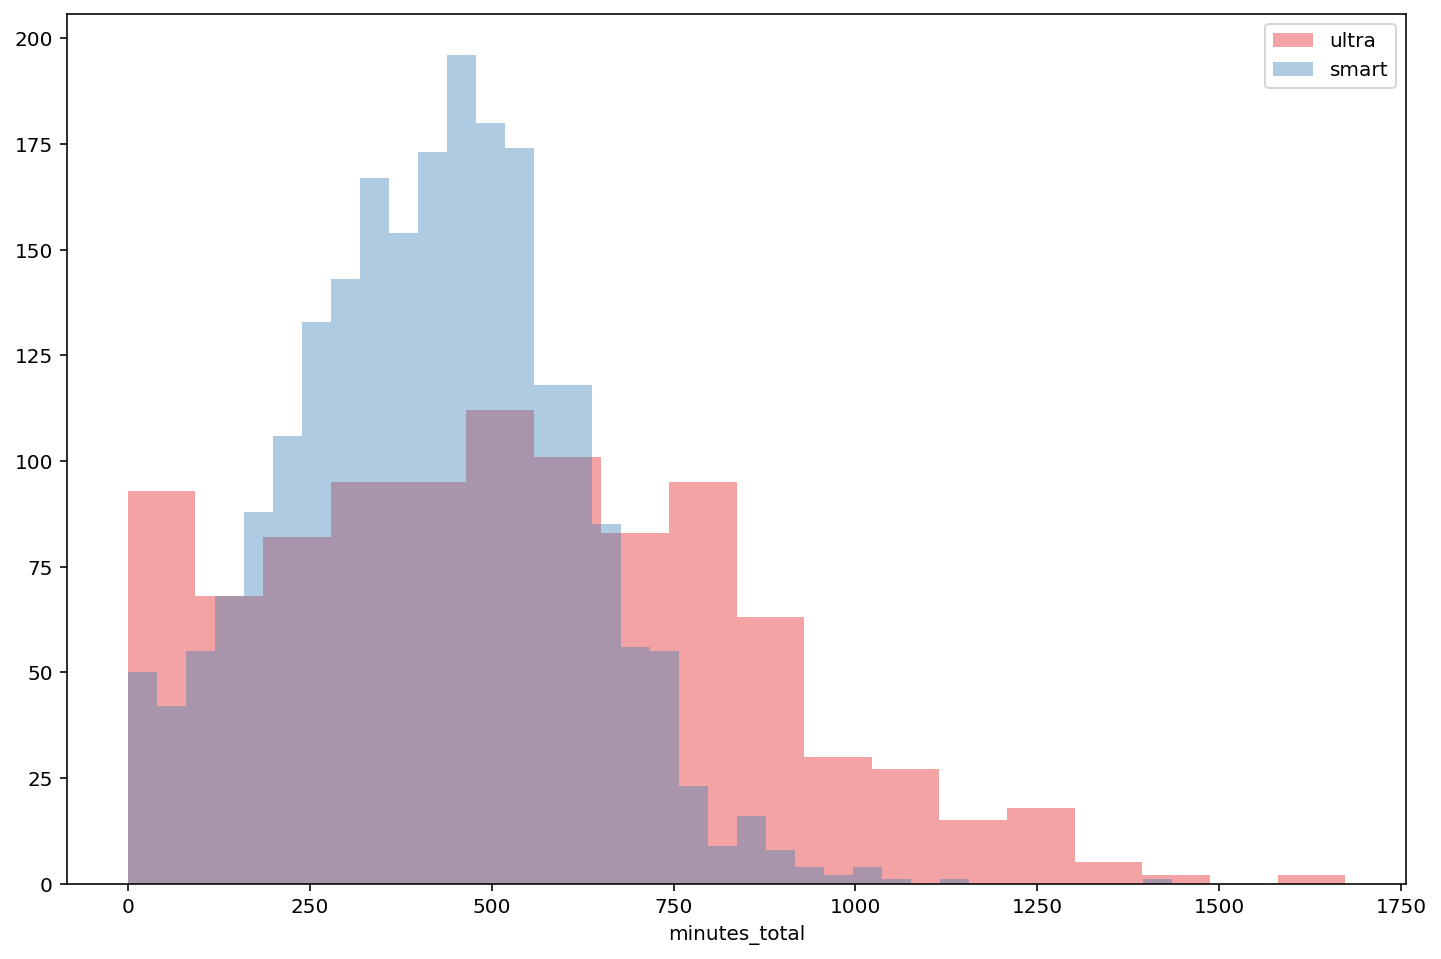

In [58]:
# графики сравнения двух тарифов по потраченным минутам

plt.figure(figsize=(12, 8))

for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff').minutes_total, label=tariff, kde=False)
    _ = plt.legend(['ultra', 'smart'])

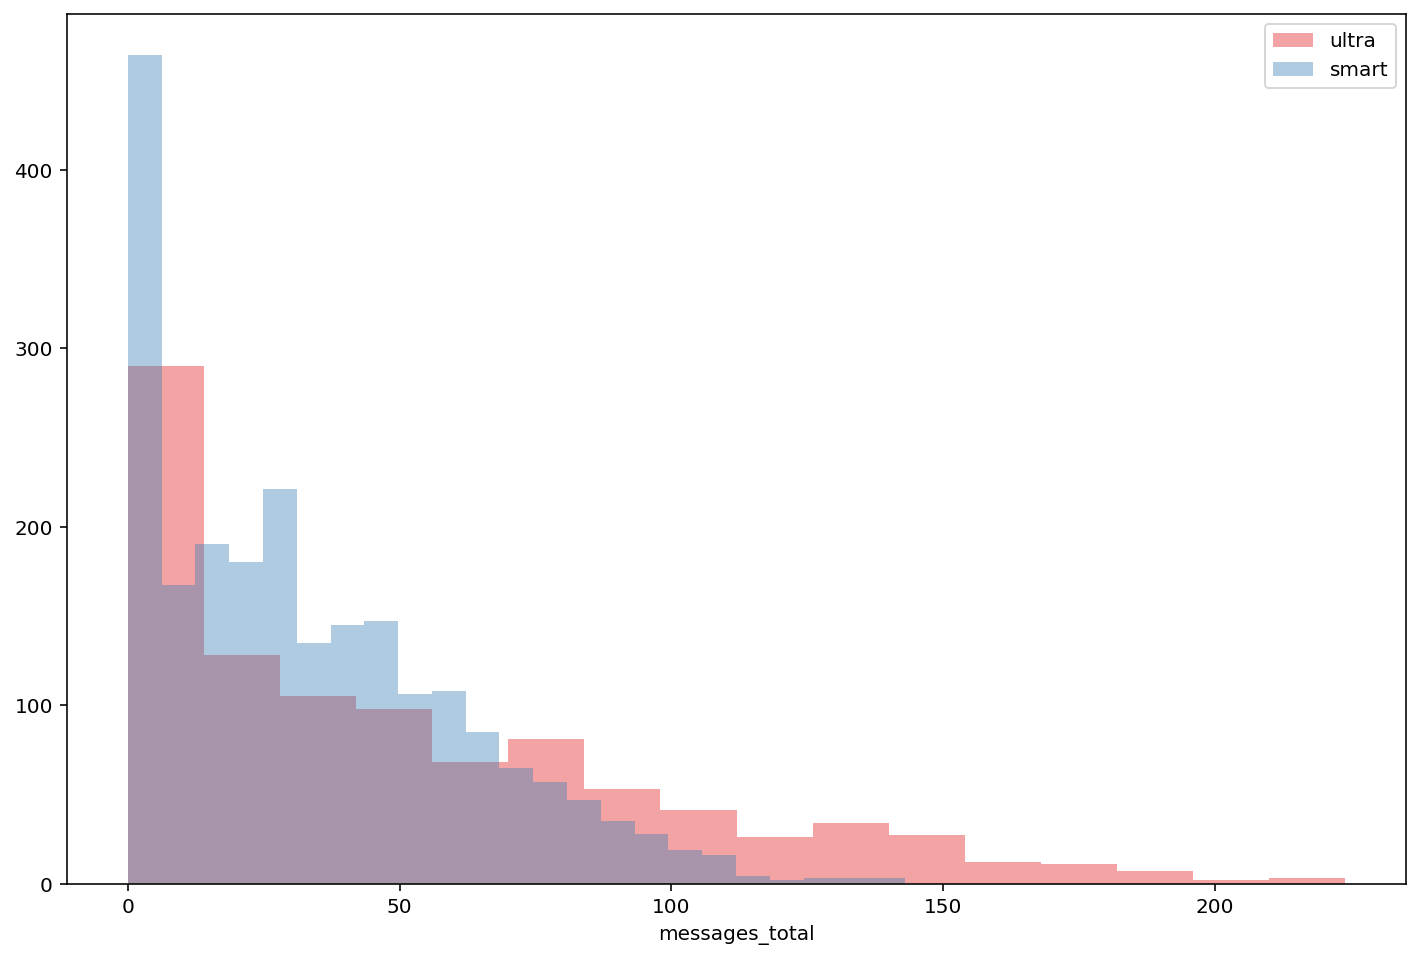

In [59]:
# графики сравнения двух тарифов по сообщениям

plt.figure(figsize=(12, 8))

for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff').messages_total, label=tariff, kde=False)
    _ = plt.legend(['ultra', 'smart'])

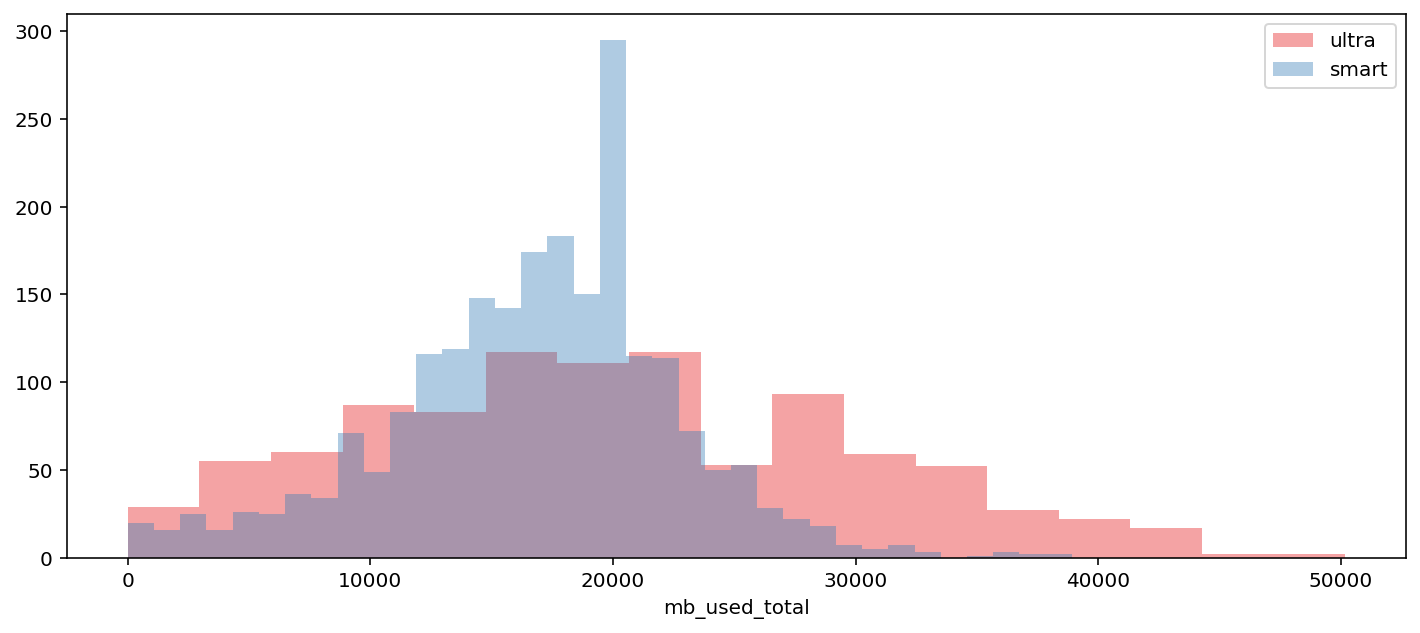

In [60]:
# графики сравнения двух тарифов по интернет-трафику

plt.figure(figsize=(12, 5))

for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff').mb_used_total, label=tariff, kde=False)
    _ = plt.legend(['ultra', 'smart'])

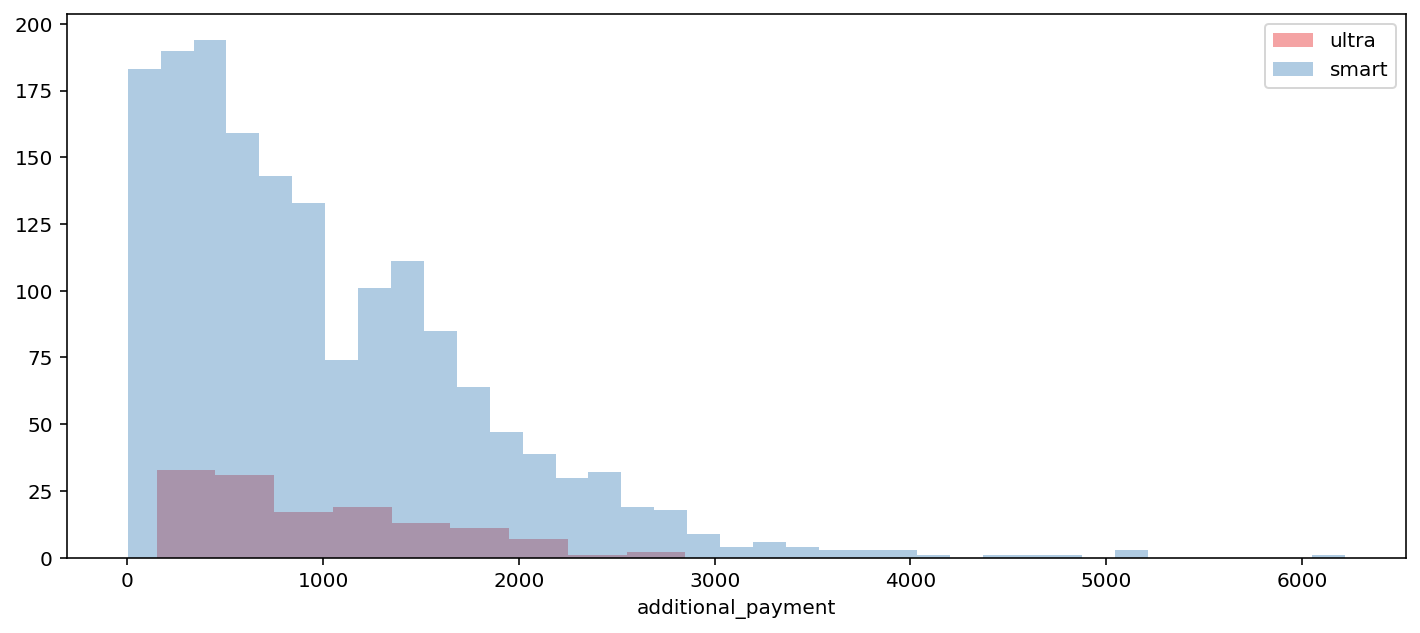

In [61]:
# графики сравнения двух тарифов по доплатам

plt.figure(figsize=(12, 5))

for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff & additional_payment > 0').additional_payment, label=tariff, kde=False)
    _ = plt.legend(['ultra', 'smart'])

### Вывод 
Гистограммы хорошо показывают различия в поведении пользователей тарифов:
- большая дисперсия у тарифа `ultra` указывает на то, что пользователи используют его очень по-разному, по сути нет четкого портрета потребителя. Из-за больших лимитов пользователи редко выходят за границы лимитов и им практически не приходится доплачивать за связь;
- у тарифа `smart` выделяются четкие моды по каждому типу связи. Поведение этих пользователей более предсказуемо и схоже между собой. Кроме того, пользователи тарифа довольно часто выходят за рамки лимита и доплачивают за связь – средний чек у них больше, чем стоимость тарифа.

На гистограммах хорошо видны пересечения зон тарифов – вероятно, это можно использовать для создания "универсального" среднего тарифа.

## Проверка гипотез

### Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

- $H_0$: средняя выручка от пользователей тарифов `ultra` и `smart` равна
- $H_1$: средняя выручка от пользователей тарифов `ultra` и `smart` различается

Нулевой гипотезой считается принимаемое по умолчанию предположение о том, что не существует связи между двумя наблюдаемыми событиями.

In [62]:
# создаем выборки с платежами пользователей тарифов
ultra_pays = df.query('tariff == "ultra"')['total_payment']
smart_pays = df.query('tariff == "smart"')['total_payment']

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    ultra_pays, smart_pays, 
    equal_var=False) # используется критерий Уэлтча, так как дисперсии выборок различаются

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


,total_payment
tariff,
smart,1021.0
ultra,1950.0


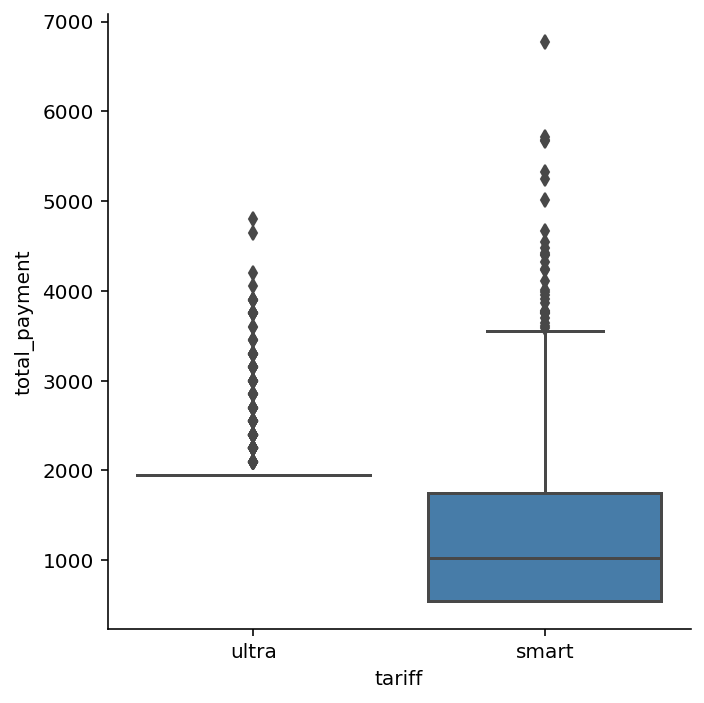

In [63]:
# создаем группировку со средней выручкой по тарифам

tariffs_pays = df \
    .groupby(['tariff']) \
    .agg({'total_payment' : 'median'})

sns.catplot(x='tariff', y='total_payment', kind='box', data=df, orient='v');
tariffs_pays

**Отвергаем нулевую гипотезу.**

Построив группировку и визуализировав даные, видим, что выручка от тарифа `ultra` больше тарифа `smart` почти в 2 раза. 
Кроме того, пользователи тарифа `smart` переплачивают сверх тарифной платы больше. 

Средняя выручка от пользователей тарифов «Ультра» и «Смарт» различаются.

### Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

- $H_0$: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов
- $H_1$: средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов

Нулевой гипотезой считается принимаемое по умолчанию предположение о том, что не существует связи между двумя наблюдаемыми событиями.

In [64]:
# создаем выборки с платежами из Москвы и остальных регионов
msk_pays = df.query('city == "Москва"')['total_payment']
russia_pays = df.query('city != "Москва"')['total_payment']

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    msk_pays, russia_pays, 
    equal_var=False) # используется критерий Уэлтча, так как дисперсии выборок различаются

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


,total_payment
region,
Другой регион,1583.0
Москва,1750.0


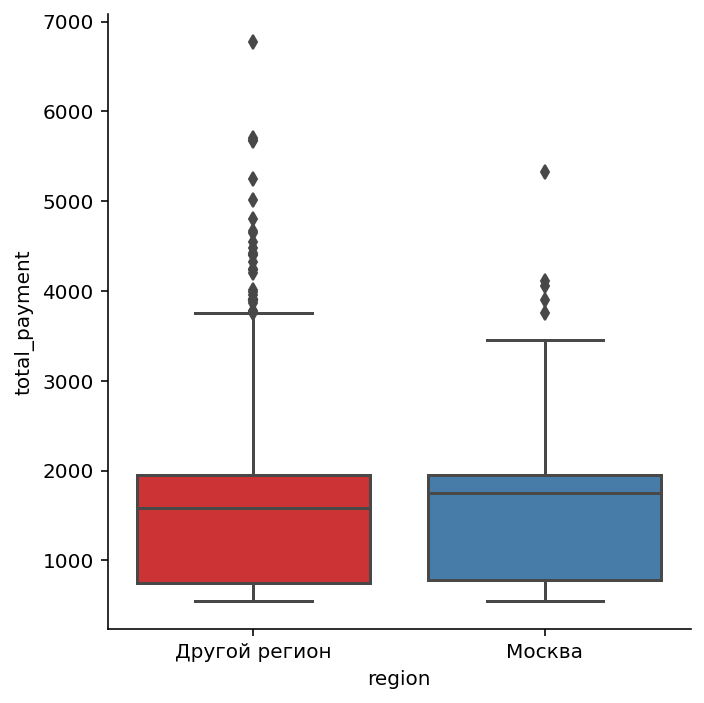

In [65]:
# функция для определения региона – Москва или нет
def rus_reg(city):
    if city == 'Москва':
        return 'Москва'
    return 'Другой регион'
    
# создает столбец с обозначением региона, применив функцию
df['region'] = df['city'].apply(rus_reg)
region_pays = df \
    .groupby(['region']) \
    .agg({'total_payment' : 'median'})

sns.catplot(x='region', y='total_payment', kind='box', data=df, orient='v');
region_pays

**Нулевую гипотезу не удалось отвергнуть.**

Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов или очень близка к ней.


### Вывод

Мы проверили две гипотезы и готовы предоставить заказчику результаты анализа.

1. Нулевую гипотезу о равенстве доходов от двух тарифов получилось опровергнуть
2. Нулевую гипотезу о равенстве доходов от клиентов из разных регионов не получилось отвергнуть

## Общий вывод

Мы проанализировали выборку заказчика и сделали выводы по нескольким гипотезам.

**Результаты статистического анализа:**
- доходы от пользователей с тарифом не равны: доход от пользователей `ultra` выше, чем от пользователей `smart`. Интересно, что хотя изначально тариф `smart` более дешевый, пользователям не хватает выделенных лимитом минут, сообщений и трафика и приходится доплачивать (в среднем – 515 рублей, практически полную стоимость тарифа);
- доходы от пользователей из Москвы не отличаются от доходов от пользователей в регионах, по крайней мере разница статистически не значима. Разница в платежах составляет в среднем 120 рублей.


**Если затраты на обслуживание тарифов для оператора одинаковы, то более выгодным по доходности можно считать тариф `ultra`.**